# Edge Orientation and Morphology

This notebook contains experimentation with:
* Calculating edge orientation for grayscale images
* Applying morphological transforms for document skew estimation

Import the OpenCV & Numpy Libraries and read in refere4nce image

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math

fish_img = cv.imread('./resources/fisherman.jpg')
empire_img = cv.imread('./resources/empire.jpg')

## 1.  Image Filtering with Open CV
Convert the image to grayscale

In [2]:
fish_img_gray = cv.cvtColor(fish_img, cv.COLOR_BGR2GRAY)
empire_img_gray = cv.cvtColor(empire_img, cv.COLOR_BGR2GRAY)

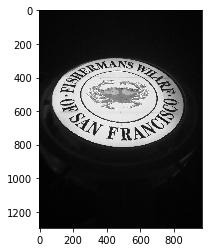

In [3]:
plt.imshow(fish_img_gray, 'gray')

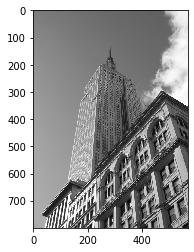

In [4]:
plt.imshow(empire_img_gray, 'gray')

Calculate the horizontal and vertical derivatives

In [5]:
D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
fish_der_x = cv.filter2D(fish_img_gray, -1, D_x)
empire_der_x = cv.filter2D(empire_img_gray, -1, D_x)

D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
fish_der_y = cv.filter2D(fish_img_gray, -1, D_y)
empire_der_y = cv.filter2D(empire_img_gray, -1, D_y)

Create an empy array same size as the image to populate

In [6]:
fish_height, fish_width = fish_img_gray.shape
ori_fish_img_gray = np.zeros((fish_height, fish_width), np.float32)

empire_height, empire_width = empire_img_gray.shape
ori_empire_img_gray = np.zeros((empire_height, empire_width), np.float32)

Scan the array and apply test

In [7]:
for i in range(0, fish_height):
    for j in range(0, fish_width):
        if float(fish_der_x[i, j]) == 0 and float(fish_der_y[i, j]) == 0:
            ori_fish_img_gray[i, j] = math.inf
        else:
            ori_fish_img_gray[i, j] = ((math.atan2(fish_der_y[i, j], fish_der_x[i, j])*180)/math.pi) + 90
            
for i in range(0, empire_height):
    for j in range(0, empire_width):
        if float(empire_der_x[i, j]) == 0 and float(empire_der_y[i, j]) == 0:
            ori_empire_img_gray[i, j] = math.inf
        else:
            ori_empire_img_gray[i, j] = ((math.atan2(empire_der_y[i, j], empire_der_x[i, j])*180)/math.pi) + 90

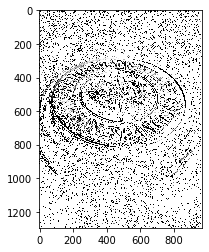

In [8]:
plt.imshow(ori_fish_img_gray, 'gray')

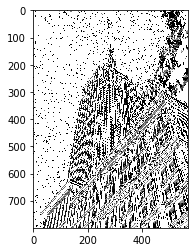

In [9]:
plt.imshow(ori_empire_img_gray, 'gray')

In [10]:
fish_ori_hist = cv.calcHist([ori_fish_img_gray],[0],None,[181],[0,181])
empire_ori_hist = cv.calcHist([ori_empire_img_gray],[0],None,[181],[0,181])

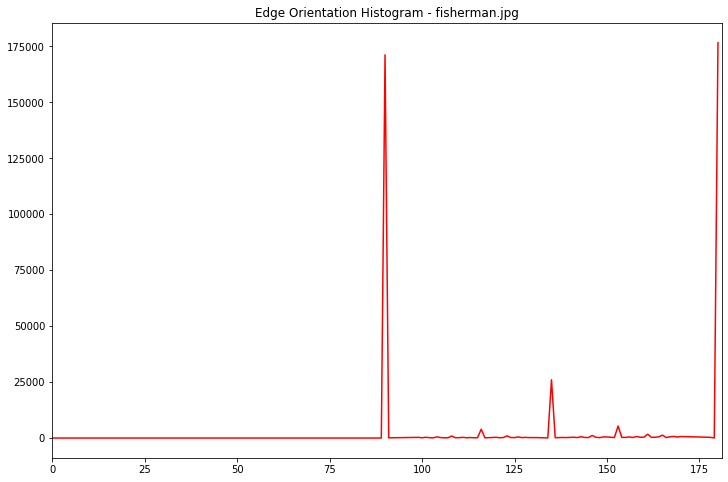

In [11]:
plt.figure(figsize=(12,8))
plt.plot(fish_ori_hist, color = 'r')
plt.xlim([0,181])
plt.title("Edge Orientation Histogram - fisherman.jpg")
plt.savefig('fisherman_histogram.png')
plt.show()

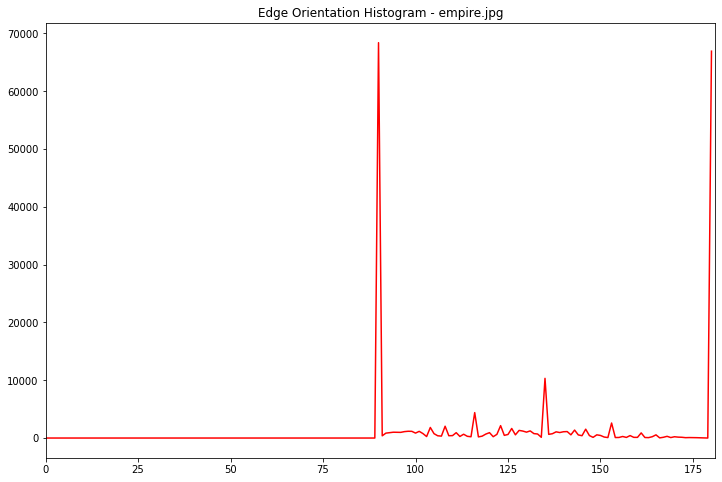

In [12]:
plt.figure(figsize=(12,8))
plt.plot(empire_ori_hist, color = 'r')
plt.xlim([0,181])
plt.title("Edge Orientation Histogram - empire.jpg")
plt.savefig('empire_edge_histogram.png')
plt.show()

## Applying morphology for document skew estimation

In this section i re-implement parts of the paper:

D. T. Nguyen et al., A robust document skew estimation algorithm using mathematical morphology. In
proceedings of the IEEE Int. Conf. Tools with Artificial Intelligence, 2007.

### 2.1 Binary Images

In [13]:
doc = cv.imread('./resources/doc.jpg', 0)
doc1 = cv.imread('./resources/doc_1.jpg', 0)

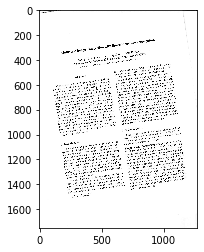

In [14]:
plt.imshow(doc, 'gray')

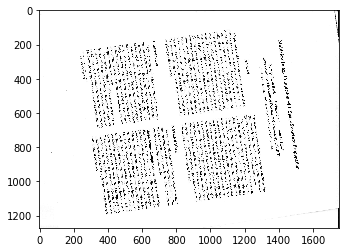

In [15]:
plt.imshow(doc1, 'gray')

### 2.2. Morphological transforms for document skew estimation

Define a few functions to perform the deskew processing tasks. This will make ti easier to try multiple images and compare the results.

In [16]:
def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]

    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
                
    return connected_components

In [17]:
import math
def FindOrientation(cc):
    mx = 0
    my = 0
    mxx = 0
    myy = 0
    mxy = 0

    for i in range(0, len(cc)):
        mx += cc[i][0] # cc[i][0] is used to store the x coordinate of pixel cc[i]
        my += cc[i][1] # cc[i][1] is used to store the y coordinate of pixel cc[i]
    mx /= len(cc)
    my /= len(cc)

    for i in range(0, len(cc)):
        dx = cc[i][0] - mx
        dy = cc[i][1] - my
        mxx += (dx * dx)
        myy += (dy * dy)
        mxy += (dx * dy)
    mxx /= len(cc)
    myy /= len(cc)
    mxy /= len(cc)

    theta = - math.atan2(2 * mxy, mxx - myy) / 2
    return theta

In [18]:
import statistics
def deskew(doc, reverse_closing_se=False):
    threshold = 200
    ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
    
    doc_bin = 255 - doc_bin
    
    if reverse_closing_se:
        closing_se = np.ones((15, 1), np.int)
    else: 
        closing_se = np.ones((1, 15), np.int)
        
    closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
    
    opening_se = np.ones((8, 8), np.int)
    opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
    
    num_labels, labels_im = cv.connectedComponents(opening)
    
    connected_components = ExtractConnectedComponents(num_labels, labels_im)
    
    orientations = np.zeros(num_labels, np.float32)
    for i in range(0, num_labels):
        orientations[i] = FindOrientation(connected_components[i])
        
    orientation = statistics.median(orientations)
    
    height, width = doc.shape
    c_x = (width - 1) / 2.0
    c_y = (height - 1) / 2.0
    c = (c_x, c_y)

    M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
    doc_deskewed = cv.warpAffine(doc, M, (width, height))
    
    return 255-doc_bin, closing, opening, doc_deskewed

Apply deskew function to doc and doc1 images

In [19]:
doc_bin, doc_closing, doc_opening, doc_deskewed = deskew(doc=doc)
doc1_bin, doc1_closing, doc1_opening, doc1_deskewed = deskew(doc=doc1)
doc1_bin_reversed, doc1_closing_reversed, doc1_opening_reversed, doc1_deskewed_reversed = deskew(doc=doc1, reverse_closing_se=True)

Write results of deskews out to files for each doc image

In [20]:
cv.imwrite('doc_bin.png', doc_bin)
cv.imwrite('doc_closing.png', doc_closing)
cv.imwrite('doc_opening.png', doc_opening)
cv.imwrite('doc_deskewed.png', doc_deskewed)

True

In [21]:
cv.imwrite('doc1_bin.png', doc1_bin)
cv.imwrite('doc1_closing.png', doc1_closing)
cv.imwrite('doc1_opening.png', doc1_opening)
cv.imwrite('doc1_deskewed.png', doc1_deskewed)

True

In [22]:
cv.imwrite('doc1_bin_reversed.png', doc1_bin_reversed)
cv.imwrite('doc1_closing_reversed.png', doc1_closing_reversed)
cv.imwrite('doc1_opening_reversed.png', doc1_opening_reversed)
cv.imwrite('doc1_deskewed_reversed.png', doc1_deskewed_reversed)

True

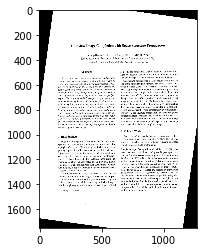

In [23]:
plt.imshow(doc_deskewed, 'gray')

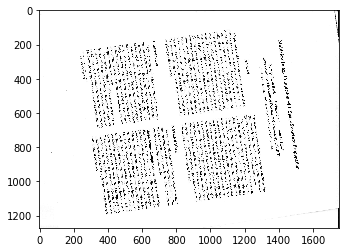

In [24]:
plt.imshow(doc1_deskewed, 'gray')

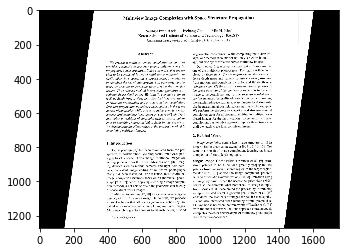

In [25]:
plt.imshow(doc1_deskewed_reversed, 'gray')